<a href="https://colab.research.google.com/github/LDY681/CITS4012/blob/master/CITS4012_Lab09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Lab09


In this lab, we will introduce [ktrain](https://github.com/amaiya/ktrain), which is a lightweight python wrapper for the deep learning library - [Tensorflow Keras](https://www.tensorflow.org/api_docs/python/tf/keras) (and other libraries), to help build, train, and deploy neural networks and other machine learning models with few lines of code.

# 1.Introduction to ktrain - Bert text classification model

As is introduced in the lecture, there are variants of **pretrained models** which already learned and encoded some useful semantic patterns from the pretraining corpus based on the pretraining tasks. ktrain provides a range of pre-trained models that can be directly used. Let's first try to train a text classification model on top of the Bert using ktrain.



## Installing ktrain

Install `transformers` and restart the session after the installation.

*(No need to run this command again after restarting the session)*

In [2]:
#! After run this, disconnect and delete runtime, restart runtime and don't run this code
#! TODO run on section2 and also lab9 E1, run this code, restart session, dont install again!
!pip install transformers==4.37.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 39.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 88.0 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.40.2
    Uninstalling transformers-4.40.2:
      Successfully uninstalled transformers-4.40.2


In [1]:
import transformers
transformers.__version__

'4.37.2'

We can install `ktrain` directly using pip.

In [2]:
!pip install ktrain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 26.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 44.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 kB 39.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for ktrain: filename=ktrain-0.41.3-py3-none-any.whl size=25316960 sha256=aa72a7c909f300da380872401369c242060c5b2adb5a7d96c1f6f7dece70fbc6
  Stored in directory: /root/.cache/pip/wheels/fc/76/11/5b953090eebf531f660948a30cd26e70260619f6480f186a5a
  Created wheel for keras_bert: filename=

## Data preperation

Let's use the 20ng news datasets loaded from sklearn in Lab 4.

In [ ]:
from sklearn.datasets import fetch_20newsgroups # collect 5 classes (5 types of news data). Note that 20newsgroup dataset has 20 classes)
categories = ['alt.atheism', 'soc.religion.christian','comp.graphics', 'sci.med', 'misc.forsale']
twenty_train = fetch_20newsgroups(subset='train',categories=categories, shuffle=True, random_state=42)

# Get the training set
train_b = fetch_20newsgroups(subset='train',
   categories=categories, shuffle=True, random_state=42)

# Get the validation set
test_b = fetch_20newsgroups(subset='test',
   categories=categories, shuffle=True, random_state=42)

x_train = train_b.data # Get the raw text
y_train = train_b.target # Get the target/label indexes
x_test = test_b.data
y_test = test_b.target

# train_b data looks like:
# From: xxx
# Subject: xxxx
# params other metas
# Lines: xxx
# target: index of the target/label
print('size of training set: %s' % (len(x_train)))
print('size of validation set: %s' % (len(x_test)))
print('classes: %s' % (train_b.target_names)) # get the target/label set (the order aligns with the target/label indexes above)


size of training set: 2842
size of validation set: 1892
classes: ['alt.atheism', 'comp.graphics', 'misc.forsale', 'sci.med', 'soc.religion.christian']


## Easy data processing using Bert input format

ktrain provides a range of tools for preprocessing various of data. We can easily prepare the data based on the Bert input format using the Bert tokenizer/preprocessor provided by ktrain.

Here, we use the [`texts_from_array()`](https://amaiya.github.io/ktrain/text/index.html#ktrain.text.texts_from_array) from ktrain.text, which loads and preprocesses text data from arrays (as we prepared the raw data as arrays already in the previous section). As can be seen that, all we need to do is to pass the parameters list as required:

*   `x_train`: *list* of training texts
*   `y_train`: *list* of target labels of training set
*   `x_test`: *list* of test texts
*   `y_test`: *list* of target labels of test set
*   `class_names`: *list* of strings representing class labels (required when list of target labels above are indexes)
*   `preprocess_mode`: *str*, either 'standard' for normal tokenization, or one of {'bert', 'distillbert'} tokenization and preprocessing for use with BERT/DistilBert model later.
*   `maxlen`: *integer* specifying the max length allowed for each document/text   

In [ ]:
import ktrain
from ktrain import text

# The returned values:
# x_train/x_test: preprocessed training/test text in forms of padded index sequences
# y_train/y_test: one-hot encoded target labels of training/test set
# preproc: a ktrain.text.TextProcessor instance, which is the preprocessor used for the current preprocessing, which can be used for building a model later (see the next section)
(x_train,  y_train), (x_test, y_test), preproc = text.texts_from_array(x_train=x_train, y_train=y_train,
                                                                       x_test=x_test, y_test=y_test,
                                                                       class_names=train_b.target_names,
                                                                       preprocess_mode='bert',
                                                                       maxlen=350)

downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


task: text classification


Easy with one line of code right? Alternatively, it is also possible to load data in other format instead of arrays, such as csv ([texts_from_csv()](https://amaiya.github.io/ktrain/text/index.html#ktrain.text.texts_from_csv), pandas dataframe ([texts_from_df()](https://amaiya.github.io/ktrain/text/index.html#ktrain.text.texts_from_df)) or read from a data folder ([texts_from_folder()](https://amaiya.github.io/ktrain/text/index.html#ktrain.text.texts_from_folder)).

In [ ]:
# Each character in the sentence is a word_embedding of 350 dim
print(len(x_train[0][0]), x_train[0][0])
# x_train[i] is sentence embedding, 2842 of max characters
# x_train[i][j] is character in sentence, 350 dimension each character

350 [  101  2013  1024 20116  2278  2509  8458  2595  1030 12436 18684  1012
  7570 10343  6494  1012  3968  2226  3395  1024  3609  3291  1012  3210
  1024  1022  1045  2572 13722  1999  1037  3609  3746  1998  2009  3504
  2986  2006  1996  3898  1012  2043  1045  4991  2009  2046  7473  2595
  1010  1038  8737  1010 21025  2546  6764  2061  2004  2000  2131  2009
  2046  5796  3645  1996  6087  2288  2172  9442  1012  2005  2742  1996
  3756  2015  2150  2317  1012  2151  4784  1029  4283  4907 20116  2278
  2509  8458  2595  1030 12436  2595  2278  1012  7570 10343  6494  1012
  3968  2226   102     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     

## Model building

Just like the data preprocessing, we can also build neural networks easily with ktrain. The one-line code below build the Bert text classification model, by calling the [text.text_classifier()](https://amaiya.github.io/ktrain/text/index.html#ktrain.text.text_classifier) and specifying the model name as 'bert'. The parameters here we are passing are:


*   `name`: *str*, specifying one of the models available from ktrain, such as 'bert' for BERT text classification, 'distillbert' for DistilBert model, 'bigru' for Bidirectional GRU with pretrained vectors etc.
*   `train_data`: *tuple* of (x_train, y_train)
*   `preproc`: a *ktrain.text.TextProcessor* instance



In [ ]:
# This returns us a Keras Model instance
model = text.text_classifier(name = 'bert', train_data=(x_train, y_train), preproc=preproc)

Is Multi-Label? False
maxlen is 350


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


done.


In [ ]:
# We can see a model structure summary by calling the .summary()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input-Token (InputLayer)    [(None, 350)]                0         []                            
                                                                                                  
 Input-Segment (InputLayer)  [(None, 350)]                0         []                            
                                                                                                  
 Embedding-Token (TokenEmbe  [(None, 350, 768),           2344089   ['Input-Token[0][0]']         
 dding)                       (30522, 768)]               6                                       
                                                                                                  
 Embedding-Segment (Embeddi  (None, 350, 768)             1536      ['Input-Segment[0][0]'] 

## Model training

Once we've built the Bert text classification model (Keras Model), we can then train it with the ktrain Learner, which allows us to tune and train the Keras models. To do so, we can create a ktrain Learner by calling the [get_learner()](https://amaiya.github.io/ktrain/#ktrain.get_learner):



*   `model`: the keras model
*   `train_data`/`val_data`: either a *tuple* or *generator*, in the code below we prepare the train/validation data as a tuple which contains the training set text indexes (`x_train`) and the one-hot encoded ground truth labels (`y_train`).
*   `batch_size`: *integer*, specifying the batch size used in training, default is 32.




In [ ]:
# This returns us a Learner instance that can be used to train and tune the Keras model.
learner = ktrain.get_learner(model=model, train_data=(x_train, y_train), val_data=(x_test, y_test), batch_size=8)

More specifically, it returns us the [BERTTextClassLearner](https://amaiya.github.io/ktrain/text/learner.html#ktrain.text.learner.BERTTextClassLearner) since we configured the model as the Bert text classification model (refer to the Model building section above)

In [ ]:
type(learner)

ktrain.text.learner.BERTTextClassLearner

The BERTTextClassLearner is inherited from the [ArrayLearner](https://amaiya.github.io/ktrain/core.html#ktrain.core.ArrayLearner) class, which is a subclass of the [Learner](https://amaiya.github.io/ktrain/core.html#ktrain.core.Learner) class. Thus, we can use the inherited function [.fit()](https://amaiya.github.io/ktrain/core.html#ktrain.core.ArrayLearner.fit) to train the model directly. We can specify the learning rate (`lr`) and the number of epochs (`n_cycles`).

In [ ]:
# Let's train one epoch only for now
# Warning: the training may take some time
# Note: if you encounter OOM (out of memory issue), you may try to reduce the maxlen in the preprocessing stage or/and reduce the batch size above, which could be helpful
learner.fit(lr=2e-5, n_cycles=1)

356/356 [==============================] - 353s 925ms/step - loss: 0.3801 - accuracy: 0.8666 - val_loss: 0.1916 - val_accuracy: 0.9323


## Model evaluation

Similar to the model training above, the model evaluation can be also done easily with one line of code using ktrain learner, after the training is finished. We can call the [.validate()](https://amaiya.github.io/ktrain/core.html#ktrain.core.Learner.validate) from the learner. By default, it uses the validation data (val_data) we spplied to the ktrain.get_learner in the model training section. Alternatively, we can also pass new test data as the test_data parameter.

Here, we pass the list of the class names (`class_names`) to be used in classification report (otherwise the class integer IDs will be used instead).

In [ ]:
# It returns the confusion matrix based on the evaluation
cm = learner.validate(class_names=preproc.get_classes())

60/60 [==============================] - 55s 855ms/step
                        precision    recall  f1-score   support

           alt.atheism       0.80      0.94      0.87       319
         comp.graphics       0.97      0.93      0.95       389
          misc.forsale       0.97      0.97      0.97       390
               sci.med       0.97      0.92      0.94       396
soc.religion.christian       0.94      0.90      0.92       398

              accuracy                           0.93      1892
             macro avg       0.93      0.93      0.93      1892
          weighted avg       0.94      0.93      0.93      1892



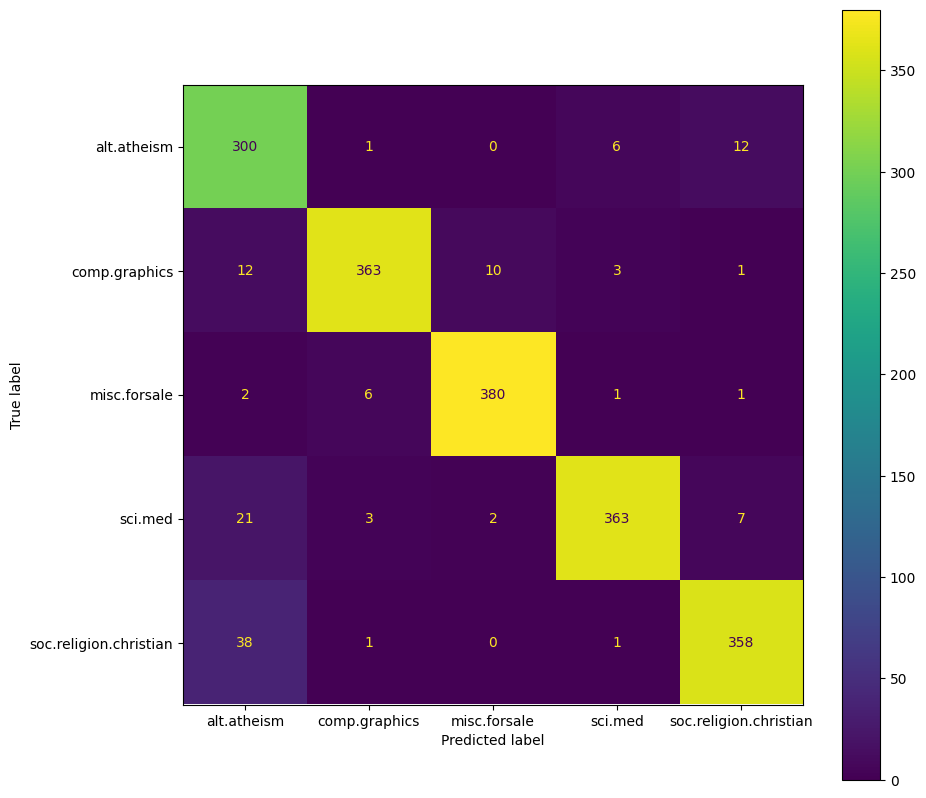

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# We can easily visualize the confusion matrix with the returned confusion matrix
plt.rcParams["figure.figsize"] = (10,10) # adjust the figure size
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=preproc.get_classes())
disp.plot()
plt.show()

## Inference with the trained model

To use the trained model above, we can call the [learner.get_predictor()](https://amaiya.github.io/ktrain/core.html#ktrain.core.get_predictor) to obtain a Predictor object that allows to make predictions on newly coming **raw data**. We just need to pass the trained model from the learner together with the preprocessor.

In [ ]:
predictor = ktrain.get_predictor(model=learner.model, preproc=preproc)

In [ ]:
predictor.get_classes() #The predictor can also access the list of target labels directly

['alt.atheism',
 'comp.graphics',
 'misc.forsale',
 'sci.med',
 'soc.religion.christian']

In [ ]:
# To predict the new data, we can simply input the raw text into the .predict() function
# it will return the predicted label
sample_raw_text = 'this is a news article from science domain'
predictor.predict(sample_raw_text)

'comp.graphics'

In [ ]:
# By setting the return_proba=True, it will return the probability distribution instead
predictor.predict(sample_raw_text, return_proba=True)

array([0.12355984, 0.60483336, 0.03211657, 0.20958841, 0.02990184],
      dtype=float32)

In [ ]:
# We can also predict a list of raw texts at once
sample_raw_textlist = ['this is a news article from science domain', 'this is an artical discussing about beliefs of people']
predictor.predict(sample_raw_textlist)

['comp.graphics', 'alt.atheism']

In [ ]:
# By setting the return_proba=True, it will return the probability distribution instead
predictor.predict(sample_raw_textlist, return_proba=True)

array([[0.12355981, 0.6048329 , 0.03211655, 0.20958889, 0.02990188],
       [0.67554283, 0.0108675 , 0.00738666, 0.02164814, 0.28455487]],
      dtype=float32)

## Save and load the trained model

Save the predictor using `predictor.save()`, which includes the model and preprocessor. After saving the predictor, you can see a 'BertTextClassifier' folder there, which contains both the model file (tf_model.h5) and the preprocessor (tf_model.preproc).

In [ ]:
# Save the predictor using predictor.save(path_to_model)
predictor.save('BertTextClassifier')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


To load the predictor, we can simply call the `ktrain.load_predictor()` with specifying the path to the saved model.

In [ ]:
# load the predictor using ktrain.load_predictor(path_to_model)
# this will return us the saved the predictor
p = ktrain.load_predictor('BertTextClassifier')

# then the predictor can be used as usual
sample_raw_textlist = ['this is a news article from science domain', 'this is an artical discussing about beliefs of people']
predictor.predict(sample_raw_textlist)

# with the loaded predictor, if you want to resume the training again, you can initialize the learner:
# learner = ktrain.get_learner(p.model, train_data=(x_train, y_train), val_data=(x_test, y_test), batch_size=8)

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


['comp.graphics', 'alt.atheism']

We can also load the preprocessor directly for preprocessing some text.

In [ ]:
import pickle
# loading preprocess and model file
features = pickle.load(open('BertTextClassifier/tf_model.preproc','rb'))

text = 'hello this is an test text'
preproc_text = features.preprocess([text])
preproc_text[0][0].shape # the preprocessor convert the raw text into the padded index of length 350 (maxlen)

(350,)

# 2.Sentence Pair Classification with ktrain using pretrained models

In this example, we will use the Microsoft Research Paraphrase Corpus (MRPC) to build a model that can tell if one sentence is the paraphrase of another, which is a sentence pair classification task. We will utilize the pretrained models such as Bert and distillbert.

## Data preperation

First, let's download the MRPC training and test dataset.

In [ ]:
!wget https://dl.fbaipublicfiles.com/senteval/senteval_data/msr_paraphrase_train.txt # training set
!wget https://dl.fbaipublicfiles.com/senteval/senteval_data/msr_paraphrase_test.txt # test set

--2024-05-15 04:12:15--  https://dl.fbaipublicfiles.com/senteval/senteval_data/msr_paraphrase_train.txt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.155.173.80, 18.155.173.79, 18.155.173.40, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.155.173.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1047044 (1023K) [text/plain]
Saving to: ‘msr_paraphrase_train.txt’

msr_paraphrase_trai 100%[===================>]   1023K  --.-KB/s    in 0.05s   

2024-05-15 04:12:15 (21.0 MB/s) - ‘msr_paraphrase_train.txt’ saved [1047044/1047044]

--2024-05-15 04:12:15--  https://dl.fbaipublicfiles.com/senteval/senteval_data/msr_paraphrase_test.txt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.155.173.80, 18.155.173.79, 18.155.173.40, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.155.173.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 441275 (431K) [text/plain]
Saving to: 

Let's have a look at the raw dataset via pandas dataframe.

In [ ]:
import pandas as pd
import csv
TRAIN = 'msr_paraphrase_train.txt'
TEST = 'msr_paraphrase_test.txt'
train_df = pd.read_csv(TRAIN, delimiter='\t', quoting=csv.QUOTE_NONE)
test_df = pd.read_csv(TEST, delimiter='\t', quoting=csv.QUOTE_NONE)

In [ ]:
train_df.head()

,Quality,#1 ID,#2 ID,#1 String,#2 String
0,1,702876,702977,"Amrozi accused his brother , whom he called "" ...","Referring to him as only "" the witness "" , Amr..."
1,0,2108705,2108831,Yucaipa owned Dominick 's before selling the c...,Yucaipa bought Dominick 's in 1995 for $ 693 m...
2,1,1330381,1330521,They had published an advertisement on the Int...,"On June 10 , the ship 's owners had published ..."
3,0,3344667,3344648,"Around 0335 GMT , Tab shares were up 19 cents ...","Tab shares jumped 20 cents , or 4.6 % , to set..."
4,1,1236820,1236712,"The stock rose $ 2.11 , or about 11 percent , ...",PG & E Corp. shares jumped $ 1.63 or 8 percent...


We will use the `#1 String` and `#2 String` columns to prepare the arrays of sentence pairs, and use the `Quality` column to prepare the target label.

In [ ]:
x_train = train_df[['#1 String', '#2 String']].values
y_train = train_df['Quality'].values
x_test = test_df[['#1 String', '#2 String']].values
y_test = test_df['Quality'].values


# IMPORTANT: data format for sentence pair classification is list of tuples of form (str, str)
x_train = list(map(tuple, x_train))
x_test = list(map(tuple, x_test))

In [ ]:
print(x_train[0])
print(y_train[0])

('Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .', 'Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .')
1


## Build and train the Bert/DistillBert model

ktrain provide the [Transformer](https://amaiya.github.io/ktrain/text/index.html#ktrain.text.Transformer) class, which can be easily used with the hugging face pretrained transformer models (see the [models available](https://huggingface.co/transformers/v3.3.1/pretrained_models.html)).

In [ ]:
import ktrain
from ktrain import text

# As can be seen from the pretrained model list (https://huggingface.co/transformers/v3.3.1/pretrained_models.html)
# we can load any of the pretrained model by simply specifying the model name
MODEL_NAME = {'bert' : 'bert-base-uncased', 'distillbert': 'distilbert-base-uncased'}

# Using the bert model
# t = text.Transformer(model_name = MODEL_NAME['bert'], maxlen=128, class_names=['not paraphrase', 'paraphrase'])

# Using the distillbert model - you can uncomment to try with distillbert
t = text.Transformer(model_name = MODEL_NAME['distillbert'], maxlen=128, class_names=['not paraphrase', 'paraphrase'])

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
# Preprocess the train/val data using the .preprocess_train() and .preprocess_test() functions
trn = t.preprocess_train(x_train, y_train)
val = t.preprocess_test(x_test, y_test)

preprocessing train...
language: en
sentence pairs detected


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Is Multi-Label? False
preprocessing test...
language: en
sentence pairs detected


In [3]:
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=32) # lower bs if OOM occurs
learner.fit(lr=5e-5, n_cycles=1) #use epoch 1 for demonstration

NameError: name 't' is not defined

## Make Predictions

Let's do some predictions using the samples from `x_test`.

In [ ]:
predictor = ktrain.get_predictor(learner.model, t)

In [ ]:
print('Ground_truth: '+predictor.get_classes()[y_test[0]])
print('Predicted: '+predictor.predict(x_test[0]))

Ground_truth: paraphrase


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 197, in assert_input_compatibility
        raise ValueError(

    ValueError: Missing data for input "Input-Token". You passed a data dictionary with keys ['input_ids', 'attention_mask']. Expected the following keys: ['Input-Token', 'Input-Segment']


In [ ]:
print('Ground_truth: '+predictor.get_classes()[y_test[4]])
print('Predicted: '+predictor.predict(x_test[4]))

Ground_truth: not paraphrase
Predicted: paraphrase


# Lab 9 Exercise
Please complete the following **question E1** for Lab 9 and check with your Lab Facilitator in the lab.

**Submission Due**: Your Lab 10 (in Week 11)

**Submission Method**: Show your final code to your Lab Facilitator during the Lab.

## E1. Play with different pretrained models for text classification using ktrain


Utill now, you've got familar with the procedure of building the pretraind models for text classification. As can be seen from the section 2 that it is possible and easy to build a pretrained transformer model for text classification (by changing the model name to the expected one). In this exercise, please try to:


*   build and train a `RoBERTa` (any RoBERTa variant from the [model list](https://huggingface.co/transformers/v3.3.1/pretrained_models.html) is fine) model for news classification, using the 20ng news dataset below. You can decide # epochs, batch_size, max_len etc. by yourself.
*   after the training is finished, please use any ***two*** samples from the test set data (`x_test`) to do the prediction, and print out both the ground truth label and the model predicted label for comparison. You can refer to the sample output in the end.

Hint: You can follow the procedure in section 2 and apply it with the 20ng dataset, and change the model type to the RoBERTa variant.



In [5]:
from sklearn.datasets import fetch_20newsgroups # collect 5 classes (5 types of news data). Note that 20newsgroup dataset has 20 classes)
categories = ['alt.atheism', 'soc.religion.christian','comp.graphics', 'sci.med', 'misc.forsale']
twenty_train = fetch_20newsgroups(subset='train',categories=categories, shuffle=True, random_state=42)

# Get the training set
train_b = fetch_20newsgroups(subset='train',
   categories=categories, shuffle=True, random_state=42)

# Get the validation set
test_b = fetch_20newsgroups(subset='test',
   categories=categories, shuffle=True, random_state=42)

x_train = train_b.data # Get the raw text
y_train = train_b.target # Get the target/label indexes
x_test = test_b.data
y_test = test_b.target

print(x_train[0], y_train[0])
print('size of training set: %s' % (len(x_train)))
print('size of validation set: %s' % (len(x_test)))
print('classes: %s' % (train_b.target_names)) # get the target/label set (the order aligns with the target/label indexes above)


From: csc3phx@vaxa.hofstra.edu
Subject: Color problem.
Lines: 8


I am scanning in a color image and it looks fine on the screen.  When I 
converted it into PCX,BMP,GIF files so as to get it into MS Windows the colors
got much lighter.  For example the yellows became white.  Any ideas?

thanks
Dan
csc3phx@vaxc.hofstra.edu
 1
size of training set: 2842
size of validation set: 1892
classes: ['alt.atheism', 'comp.graphics', 'misc.forsale', 'sci.med', 'soc.religion.christian']


In [3]:
import ktrain
from ktrain import text

In [6]:
# Using the roberta model - you can uncomment to try with distillbert
classes = train_b.target_names
t = text.Transformer(model_name = "roberta-base", maxlen=128, class_names=classes)

# Preprocess the train/val data using the .preprocess_train() and .preprocess_test() functions
trn = t.preprocess_train(x_train, y_train)
val = t.preprocess_test(x_test, y_test)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

preprocessing train...
language: en
train sequence lengths:
	mean : 275
	95percentile : 772
	99percentile : 1742


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 303
	95percentile : 888
	99percentile : 2406


In [7]:
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=32) # lower bs if OOM occurs
learner.fit(lr=5e-5, n_cycles=1) #use epoch 1 for demonstration

89/89 [==============================] - 121s 1s/step - loss: 0.6564 - accuracy: 0.7481 - val_loss: 0.2797 - val_accuracy: 0.9149


In [9]:
# Please get 2 of the test data and make prediction here. You need to print out both the ground truth label and the predicted label (refer to the sample output below)
predictor = ktrain.get_predictor(learner.model, t)
print('Test sample #1: ')
print('Ground_truth: '+predictor.get_classes()[y_test[0]])
print('Predicted: '+predictor.predict(x_test[0]))

print('Test sample #2: ')
print('Ground_truth: '+predictor.get_classes()[y_test[666]])
print('Predicted: '+predictor.predict(x_test[666]))

Test sample #1: 
Ground_truth: comp.graphics
Predicted: comp.graphics
Test sample #2: 
Ground_truth: soc.religion.christian
Predicted: soc.religion.christian


Sample output

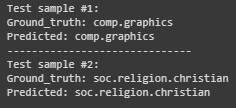